# Initializing Libraries

In [2]:
!pip install barbar

In [3]:
import numpy as np
import pandas as pd
import os
import time
import csv
import random
import matplotlib.pyplot as plt
from PIL import Image
from barbar import Bar
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

use_gpu = torch.cuda.is_available()
print(use_gpu)

True


# Pre-define Value

In [4]:
# Paths to the files with training, and validation sets.
# Each file contains pairs (path to image, output vector)
Traindata = pd.read_csv('/kaggle/input/dataset/train.csv')
Traindata = Traindata[Traindata['Path'].str.contains("frontal")] # use only frontal images 
Traindata = Traindata[500:20500]
Traindata.to_csv('/kaggle/working/train_mod.csv', index = False)
print("Train data length:", len(Traindata))

Validdata = pd.read_csv('/kaggle/input/dataset/valid.csv')
Validdata = Validdata[Validdata['Path'].str.contains("frontal")] # use only frontal images
Validdata.to_csv('/kaggle/working/valid_mod.csv', index = False)
print("Valid data length:", len(Validdata))

Testdata = Traindata.head(500) # use first 500 training data as test data (obs ratio is almost same!)
Testdata.to_csv('/kaggle/working/test_mod.csv', index = False)
print("Test data length:", len(Testdata))

pathFileTrain = '/kaggle/working/train_mod.csv'
pathFileValid = '/kaggle/working/valid_mod.csv'
pathFileTest = '/kaggle/working/test_mod.csv'

# Neural network parameters:
nnIsTrained = False     # pre-trained using ImageNet
nnClassCount = 14       # dimension of the output

# Training settings: batch size, maximum number of epochs
trBatchSize = 16
trMaxEpoch = 3

# Parameters related to image transforms: size of the down-scaled image, cropped image
imgtransResize = (320, 320)
imgtransCrop = 224

# Class names
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

Train data length: 20000
Valid data length: 202
Test data length: 500


# Create a Dataset

In [5]:

class CheXpertDataSet(Dataset):
    def __init__(self, data_PATH, image_folder_path, transform=None, policy="ones"):
        """
        data_PATH: Path to the CSV file containing image paths and corresponding labels.
        image_folder_path: Root folder where the images are located.
        transform: Optional transform to be applied to a sample.
        policy: Policy to handle uncertain labels (-1).
        """
        image_names = []
        labels = []

        with open(data_PATH, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None)  # Skip the header
            for line in csvReader:
                image_name = line[0].replace("CheXpert-v1.0-small/", "") # Adjust the path
                label = line[5:]  # Extract labels starting from column 5

                # Process labels as per original logic
                for i in range(14):
                    if label[i]:
                        a = float(label[i])
                        if a == 1:
                            label[i] = 1
                        elif a == -1:
                            if policy == "ones":
                                label[i] = 1
                            elif policy == "zeroes":
                                label[i] = 0
                            else:
                                label[i] = 0
                        else:
                            label[i] = 0
                    else:
                        label[i] = 0

                image_names.append(os.path.join(image_folder_path, image_name))
                labels.append(label)

        self.image_names = image_names
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        """Fetch an image and its labels by index."""
        image_name = self.image_names[index]
        image = Image.open(image_name).convert('RGB')
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
        return image, torch.FloatTensor(label)

    def __len__(self):
        return len(self.image_names)


# Load Datasets

In [6]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]  # mean of ImageNet dataset(for normalization)
IMAGENET_STD = [0.229, 0.224, 0.225]   # std of ImageNet dataset(for normalization)

# Tranform data
normalize = transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
transformList = []

transformList.append(transforms.Resize((imgtransCrop, imgtransCrop))) # 224
#transformList.append(transforms.RandomResizedCrop(imgtransCrop))
#transformList.append(transforms.RandomHorizontalFlip())
transformList.append(transforms.ToTensor())
#transformList.append(normalize)
transformSequence = transforms.Compose(transformList)


# Set image folder path
image_folder_base = "/kaggle/input/training-and-testing-images"  

# Initialize datasets
datasetTrain = CheXpertDataSet(pathFileTrain, image_folder_base, transformSequence, policy="ones")
print("Train data length:", len(datasetTrain))

datasetValid = CheXpertDataSet(pathFileValid, image_folder_base, transformSequence)
print("Valid data length:", len(datasetValid))

datasetTest = CheXpertDataSet(pathFileTest, image_folder_base, transformSequence, policy="ones")
print("Test data length:", len(datasetTest))


Train data length: 20000
Valid data length: 202
Test data length: 500


# Create train and test Models

In [7]:
class CheXpertTrainer():

    def train(model, dataLoaderTrain, dataLoaderVal, nnClassCount, trMaxEpoch, checkpoint):
        optimizer = optim.Adam(model.parameters(), lr = 0.0001, # setting optimizer & scheduler
                               betas = (0.9, 0.999), eps = 1e-08, weight_decay = 0) 
        loss = torch.nn.BCELoss() # setting loss function
        
        if checkpoint != None and use_gpu: # loading checkpoint
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])
            optimizer.load_state_dict(modelCheckpoint['optimizer'])
            
        # Train the network
        lossMIN = 100000
        train_start = []
        train_end = []
        for epochID in range(0, trMaxEpoch):
            train_start.append(time.time()) # training starts
            losst = CheXpertTrainer.epochTrain(model, dataLoaderTrain, optimizer, trMaxEpoch, nnClassCount, loss)
            train_end.append(time.time()) # training ends
            lossv = CheXpertTrainer.epochVal(model, dataLoaderVal, optimizer, trMaxEpoch, nnClassCount, loss)
            print("Training loss: {:.3f},".format(losst), "Valid loss: {:.3f}".format(lossv))
            
            if lossv < lossMIN:
                lossMIN = lossv
                torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 
                            'best_loss': lossMIN, 'optimizer' : optimizer.state_dict()}, 
                           'm-epoch_FL' + str(epochID + 1) + '.pth.tar')
                print('For Epoch ' + str(epochID + 1) + '--> (Saving Model State) loss = ' + str(lossv) + '\n')
            else:
                print('For Epoch ' + str(epochID + 1) + '--> (Not Saving Model State) loss = ' + str(lossv) + '\n')

        train_time = np.array(train_end) - np.array(train_start)
        print("Training time for each epoch: {} seconds".format(train_time.round(0)))
        params = model.state_dict()
        return params
       
        
    def epochTrain(model, dataLoaderTrain, optimizer, epochMax, classCount, loss):
        losstrain = 0
        model.train()

        for batchID, (varInput, target) in enumerate(Bar(dataLoaderTrain)):
            
            varTarget = target.cuda(non_blocking = True)
            varOutput = model(varInput)
            lossvalue = loss(varOutput, varTarget)
                       
            optimizer.zero_grad()
            lossvalue.backward()
            optimizer.step()
            
            losstrain += lossvalue.item()
            
        return losstrain / len(dataLoaderTrain)
    
    
    def epochVal(model, dataLoaderVal, optimizer, epochMax, classCount, loss):
        model.eval()
        lossVal = 0

        with torch.no_grad():
            for i, (varInput, target) in enumerate(dataLoaderVal):
                
                target = target.cuda(non_blocking = True)
                varOutput = model(varInput)
                
                lossVal += loss(varOutput, target)
                
        return lossVal / len(dataLoaderVal)

    
    def computeAUROC(dataGT, dataPRED, classCount):
        # Computes area under ROC curve 
        # dataGT: ground truth data
        # dataPRED: predicted data
        outAUROC = []
        datanpGT = dataGT.cpu().numpy()
        datanpPRED = dataPRED.cpu().numpy()
        
        for i in range(classCount):
            try:
                outAUROC.append(roc_auc_score(datanpGT[:, i], datanpPRED[:, i]))
            except ValueError:
                pass
        return outAUROC
    
    
    def test(model, dataLoaderTest, nnClassCount, checkpoint, class_names):
        cudnn.benchmark = True
        
        if checkpoint != None and use_gpu:
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])

        if use_gpu:
            outGT = torch.FloatTensor().cuda()
            outPRED = torch.FloatTensor().cuda()
        else:
            outGT = torch.FloatTensor()
            outPRED = torch.FloatTensor()
       
        model.eval()
        
        with torch.no_grad():
            for i, (input, target) in enumerate(dataLoaderTest):

                target = target.cuda()
                outGT = torch.cat((outGT, target), 0).cuda()

                bs, c, h, w = input.size()
                varInput = input.view(-1, c, h, w)
            
                out = model(varInput)
                outPRED = torch.cat((outPRED, out), 0)
        aurocIndividual = CheXpertTrainer.computeAUROC(outGT, outPRED, nnClassCount)
        aurocMean = np.array(aurocIndividual).mean()
        print('AUROC mean ', aurocMean)
        
        for i in range (0, len(aurocIndividual)):
            print(class_names[i], ' ', aurocIndividual[i])
        
        return outGT, outPRED

# Define the Model

In [8]:
class DenseNet121(nn.Module):
    """Model modified.
    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.
    """
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained = False)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x

# Train the model with Federated Learning

In [9]:
# FOR MULTIPLE COMMUNICATION ROUNDS
com_round = 3
fraction = 1.0
epoch = 3
batch = 48
num_clients = 5

'''
# Divide datasetTrain_ex
datasetTrain_1, datasetTrain_2, datasetTrain_3, datasetTrain_4, datasetTrain_5, dataleft = random_split(datasetTrain, 
                                                                                                        [100, 100, 100, 100, 100,
                                                                                                         len(datasetTrain) - 500])
'''
# Divide datasetTrain_real
datasetTrain_1, datasetTrain_2, datasetTrain_3, datasetTrain_4, datasetTrain_5 = random_split(datasetTrain, 
                                                                                              [4000, 4000, 4000, 4000, 4000])


# Define 5 DataLoaders
dataLoaderTrain_1 = DataLoader(dataset = datasetTrain_1, batch_size = trBatchSize,
                               shuffle = True, num_workers = 2, pin_memory = True)
dataLoaderTrain_2 = DataLoader(dataset = datasetTrain_2, batch_size = trBatchSize,
                               shuffle = True, num_workers = 2, pin_memory = True)
dataLoaderTrain_3 = DataLoader(dataset = datasetTrain_3, batch_size = trBatchSize,
                               shuffle = True, num_workers = 2, pin_memory = True)
dataLoaderTrain_4 = DataLoader(dataset = datasetTrain_4, batch_size = trBatchSize,
                               shuffle = True, num_workers = 2, pin_memory = True)
dataLoaderTrain_5 = DataLoader(dataset = datasetTrain_5, batch_size = trBatchSize,
                               shuffle = True, num_workers = 2, pin_memory = True)

# Define Valid and Test DataLoaders
dataLoaderVal = DataLoader(dataset = datasetValid, batch_size = trBatchSize, 
                           shuffle = False, num_workers = 2, pin_memory = True)
dataLoaderTest = DataLoader(dataset = datasetTest, num_workers = 2, pin_memory = True)

In [10]:
dT = [datasetTrain_1, datasetTrain_2, datasetTrain_3, datasetTrain_4, datasetTrain_5]
dLT = [dataLoaderTrain_1, dataLoaderTrain_2, dataLoaderTrain_3, dataLoaderTrain_4, dataLoaderTrain_5]

model = DenseNet121(nnClassCount).cuda() # Step 0: Initialize global model and load the model
model = torch.nn.DataParallel(model).cuda()

for i in range(com_round):
    print("----------------------------------  Round {} Start ---------------------------------- \n".format(i + 1))
    params = [None] * num_clients
    sel_clients = sorted(random.sample(range(num_clients), 
                                       round(num_clients*fraction))) # Step 1: select random fraction of clients
    
    print("The number of clients:\n", len(sel_clients))
    for j in sel_clients: # Step 2: send weights to clients
        print("(( Client {} Training Start ))\n".format(j + 1))
        train_valid_start = time.time()
        params[j] = CheXpertTrainer.train(model, dLT[j], dataLoaderVal, # Step 3: Perform local computations
                                          nnClassCount, trMaxEpoch = epoch, checkpoint = None)
        train_valid_end = time.time()
        client_time = round(train_valid_end - train_valid_start)
        print("[[ Client {} Training End: {} seconds elapsed ]] \n".format(j + 1, client_time))
        
    fidx = [idx for idx in range(len(params)) if params[idx] != None][0]
    lidx = [idx for idx in range(len(params)) if params[idx] != None][-1]
    
    for key in params[fidx]: # Step 4: return updates to server
        weights, weightn = [], []
        for k in sel_clients:
            weights.append(params[k][key]*len(dT[k]))
            weightn.append(len(dT[k]))
        params[lidx][key] = sum(weights) / sum(weightn) # weighted averaging model weights

    model = DenseNet121(nnClassCount).cuda()
    model = torch.nn.DataParallel(model).cuda()
    model.load_state_dict(params[lidx]) # Step 5: server updates global state
    print("---------------------------------- Round {} End ---------------------------------- \n".format(i + 1))
    
print("Global model trained")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------  Round 1 Start ---------------------------------- 

The number of clients:
 5
(( Client 1 Training Start ))

4000/4000: [===============================>] - ETA 2.9sss
Training loss: 0.437, Valid loss: 0.435
For Epoch 1--> (Saving Model State) loss = tensor(0.4346, device='cuda:0')

4000/4000: [===============================>] - ETA 0.4sss
Training loss: 0.402, Valid loss: 0.429
For Epoch 2--> (Saving Model State) loss = tensor(0.4288, device='cuda:0')

4000/4000: [===============================>] - ETA 0.4sss
Training loss: 0.396, Valid loss: 0.432
For Epoch 3--> (Not Saving Model State) loss = tensor(0.4319, device='cuda:0')

Training time for each epoch: [55. 53. 52.] seconds
[[ Client 1 Training End: 168 seconds elapsed ]] 

(( Client 2 Training Start ))

4000/4000: [===============================>] - ETA 0.6sss
Training loss: 0.402, Valid loss: 0.434
For Epoch 1--> (Saving Model State) loss = tensor(0.4336, device='cuda:0')

4000/4000: [======

# Test and ROC Curves

In [11]:
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderTest, nnClassCount, None, class_names)

AUROC mean  0.843725848790257
No Finding   0.9335852396514162
Enlarged Cardiomediastinum   0.7382931755201729
Cardiomegaly   0.9304996905940595
Lung Opacity   0.8025419287211739
Lung Lesion   0.8041220382992534
Edema   0.9038664432445852
Consolidation   0.754615305280528
Pneumonia   0.8264407905663511
Atelectasis   0.8217381773251757
Pneumothorax   0.8880669651547596
Pleural Effusion   0.9346333333333333
Pleural Other   0.8679513504975517
Fracture   0.7329754448752361
Support Devices   0.872832


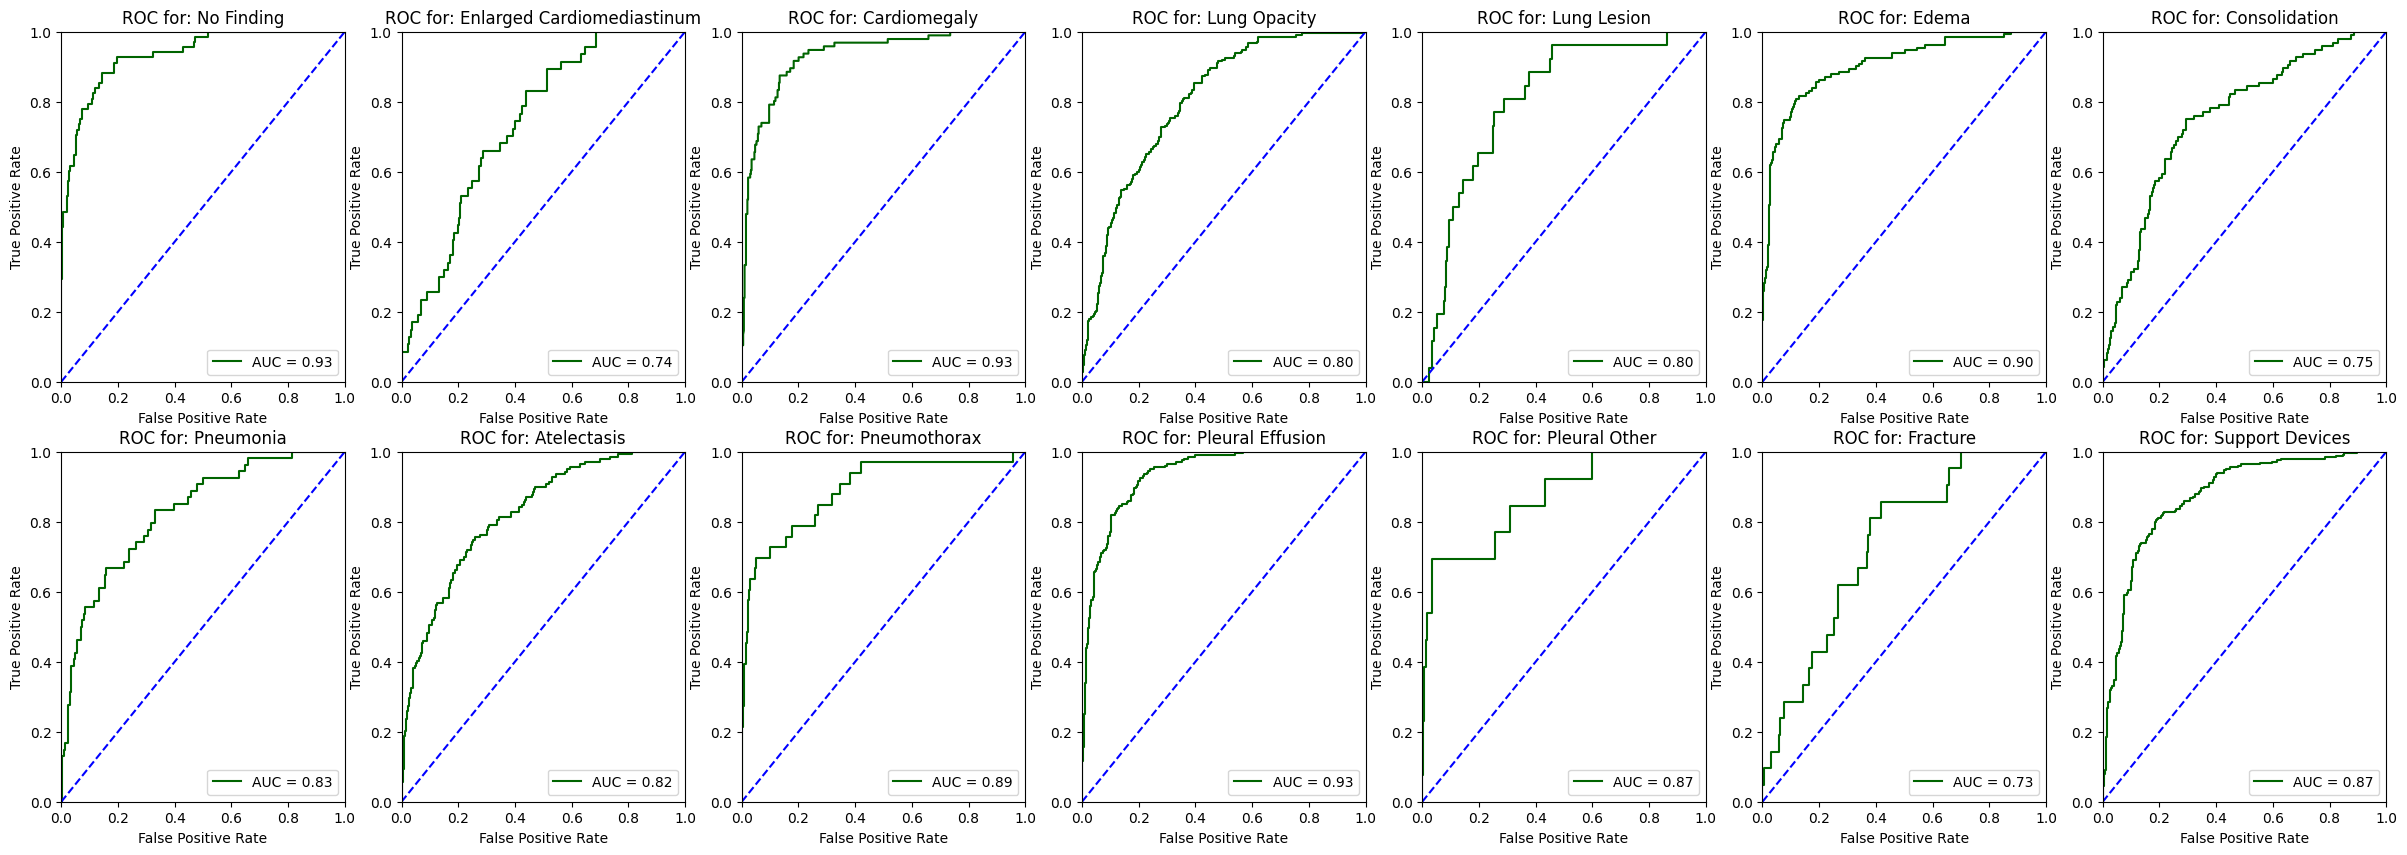

In [13]:
for i in range(nnClassCount):
    fpr, tpr, threshold = metrics.roc_curve(outGT.cpu()[:,i], outPRED.cpu()[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    f = plt.subplot(2, 7, i+1)

    plt.title('ROC for: ' + class_names[i])
    plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc, color='darkgreen')

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'b--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

fig_size = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = (30, 10)

plt.savefig("ROC.png", dpi = 1000)
plt.show()